In [247]:
import pandas as pd
from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import silhouette_score, normalized_mutual_info_score



In [248]:
df = pd.read_csv("./golestan.csv")

print(df.shape)
print(df.columns)


(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [249]:
df.head()

,hekayt,bab
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,1
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,1
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,1
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,1
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,1


In [250]:
df = df.dropna(subset=["hekayt"])
df = df.dropna(subset=["bab"])

print(df.shape)
print(df.columns)

(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [251]:
df["bab"].value_counts()

bab
8    109
2     48
1     41
3     28
5     21
7     20
4     14
6      9
Name: count, dtype: int64

In [252]:
normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()

In [253]:
base_stopwords = set(stopwords_list())

In [254]:
extra_stopwords = {
    "است", "هست", "بود", "شد", "باشد",
    "می", "هم", "را", "که", "با", "از", "برای",
    "ای", "این", "آن", "من", "تو", "ما", "شما", "او",
}

additional_stopwords = set()

for i in extra_stopwords:
    print(f'if {i} is in stopwords list? {i in base_stopwords}')
    if i not in base_stopwords: 
        additional_stopwords.add(i)

additional_stopwords

if شما is in stopwords list? True
if از is in stopwords list? True
if ای is in stopwords list? False
if شد is in stopwords list? True
if ما is in stopwords list? True
if هم is in stopwords list? True
if تو is in stopwords list? True
if را is in stopwords list? True
if او is in stopwords list? True
if این is in stopwords list? True
if برای is in stopwords list? True
if که is in stopwords list? True
if با is in stopwords list? True
if آن is in stopwords list? True
if باشد is in stopwords list? True
if من is in stopwords list? True
if است is in stopwords list? True
if هست is in stopwords list? False
if بود is in stopwords list? True
if می is in stopwords list? True


{'ای', 'هست'}

In [255]:
stopwords = base_stopwords.union(additional_stopwords)

print(len(base_stopwords))
print(len(stopwords))

389
391


In [256]:
def preprocess_hekayat(text):
    text = str(text)

    text = normalizer.normalize(text)

    tokens = word_tokenize(text)
    tokens = [t for t in tokens if re.search(r"[آ-یءئ]", t)]
    tokens = [t for t in tokens if t not in stopwords]

    tokens_stemmed = [stemmer.stem(t) for t in tokens]

    return " ".join(tokens_stemmed)


In [257]:
df["clean_hekayt"] = df["hekayt"].apply(preprocess_hekayat)

In [258]:
df.to_csv("golestan_clean.csv", index=False)
df[["hekayt", "clean_hekayt"]].head()

,hekayt,clean_hekayt
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,پادشاه شنید کشتن اسیر اشار بیچاره حال نومید مل...
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,ملوک خراس محمود سبکتگین خواب چن دید جمله ریخته...
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,ملک‌زاده شنید کوتاه حقیر برادر بلند خوب‌رو بار...
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,طایفه دزد عرب سر کوه نشسته_بودند منفذ کارو بست...
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,سرهنگ‌زاده سرا اغلم دید عقل کیاست فه فراست زای...


In [259]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 1),
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True  
)

In [260]:
x_tfidf = tfidf_vectorizer.fit_transform(df["clean_hekayt"])

In [261]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names[:30]


array(['آب', 'آباد', 'آبرو', 'آبگینه', 'آت', 'آتش', 'آثار', 'آجل', 'آحاد',
       'آخر', 'آد', 'آداب', 'آدم', 'آدمی', 'آدمیس', 'آدینه', 'آذارند',
       'آر', 'آرا', 'آراستن', 'آراسته', 'آرد', 'آرزو', 'آرمیده', 'آرند',
       'آز', 'آزاد', 'آزادگ', 'آزار', 'آزر'], dtype=object)

In [262]:
def fit_kmeans(X, k):

    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=42
    )

    kmeans.fit(X)
    labels = kmeans.labels_

    # print(kmeans.cluster_centers_)  

    return kmeans, labels


In [263]:
def plot_clusters_tsne(X, labels):

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=42
    )

    X_2d = tsne.fit_transform(X.toarray())

    plt.figure(figsize=(10, 7))
    plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=labels,
        cmap="tab10",
        s=50,
        alpha=0.90
    )

    plt.title("t-SNE Projection of K-Means Clusters", fontsize=14)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(False)
    plt.show()


In [276]:
k = 5
kmeans_final, labels_final = fit_kmeans(x_tfidf, k_final)

# cluster sizes
unique, counts = np.unique(labels_final, return_counts=True)
for lbl, cnt in zip(unique, counts):
    print(f"Cluster {lbl}: {cnt} hekayat")

threshold = 0.15 * np.mean(counts)
print("Are clusters balanced?", np.std(counts) < threshold)

# cluster–bab relationship
df_clusters = pd.DataFrame({
    "cluster": labels_final,
    "bab": df["bab"]
})
cluster_groups = df_clusters.groupby("cluster")["bab"].value_counts()
print(cluster_groups)

nmi = normalized_mutual_info_score(df["bab"], labels_final)
print("NMI:", nmi)



Cluster 0: 21 hekayat
Cluster 1: 175 hekayat
Cluster 2: 58 hekayat
Cluster 3: 19 hekayat
Cluster 4: 17 hekayat
Are clusters balanced? False
cluster  bab
0        8       8
         3       6
         2       2
         6       2
         1       1
         5       1
         7       1
1        8      47
         2      33
         1      27
         3      18
         5      18
         7      14
         4      11
         6       7
2        8      29
         1      12
         2       7
         7       5
         3       2
         5       2
         4       1
3        8      13
         2       2
         3       2
         4       2
4        8      12
         2       4
         1       1
Name: count, dtype: int64
NMI: 0.08122580558036621


In [277]:
kmeans_model, labels = fit_kmeans(x_tfidf, k)

centers = kmeans_model.cluster_centers_
print("Cluster centers shape:", centers.shape)


Cluster centers shape: (5, 5000)


In [278]:
def show_cluster_top_terms(kmeans_model, vectorizer, top_n=10):
    centers = kmeans_model.cluster_centers_
    feature_names = vectorizer.get_feature_names_out()

    for idx, center in enumerate(centers):
        print(f"\nCluster {idx} top terms:")
        top_indices = center.argsort()[::-1][:top_n]
        for i in top_indices:
            print(f"  {feature_names[i]}  ({center[i]:.3f})")


In [279]:
show_cluster_top_terms(kmeans_model, tfidf_vectorizer, top_n=10)



Cluster 0 top terms:
  اجل  (0.054)
  پا  (0.049)
  پیاده  (0.035)
  سر  (0.035)
  ماه  (0.035)
  آهسته  (0.033)
  آید  (0.031)
  عمر  (0.030)
  سال  (0.030)
  سخت  (0.029)

Cluster 1 top terms:
  دس  (0.027)
  سخن  (0.025)
  می  (0.024)
  سر  (0.023)
  که  (0.022)
  کن  (0.022)
  گر  (0.021)
  گف  (0.021)
  کس  (0.020)
  دل  (0.020)

Cluster 2 top terms:
  بی  (0.034)
  خدا  (0.034)
  ملک  (0.030)
  کار  (0.029)
  پادشاه  (0.024)
  سر  (0.023)
  چو  (0.023)
  به  (0.023)
  دل  (0.023)
  آید  (0.022)

Cluster 3 top terms:
  نیک  (0.108)
  بد  (0.100)
  رحم  (0.047)
  گدا  (0.037)
  می  (0.036)
  کن  (0.035)
  دول  (0.031)
  مر  (0.030)
  مکن  (0.030)
  آفریده  (0.028)

Cluster 4 top terms:
  دشمن  (0.085)
  خاک  (0.069)
  دوس  (0.062)
  چو  (0.055)
  کن  (0.046)
  آنگه  (0.039)
  دوست  (0.039)
  باد  (0.036)
  بنی  (0.035)
  رسد  (0.034)


In [268]:
for k in range(1, 20):
    kmeans_model, cluster_labels = fit_kmeans(x_tfidf, k)
    # plot_clusters_tsne(x_tfidf, cluster_labels)

------- k = 2 -------
Cluster 0: 47 hekayat
Cluster 1: 243 hekayat
NMI: 0.03901870068937689
Are clusters balanced? False
cluster  bab
0        8      26
         4       7
         2       6
         1       3
         5       2
         7       2
         3       1
1        8      83
         2      42
         1      38
         3      27
         5      19
         7      18
         6       9
         4       7
Name: count, dtype: int64
------- k = 3 -------
Cluster 0: 162 hekayat
Cluster 1: 61 hekayat
Cluster 2: 67 hekayat
NMI: 0.02175193654726625
Are clusters balanced? False
cluster  bab
0        8      62
         2      27
         1      26
         3      17
         5      10
         7      10
         6       6
         4       4
1        8      28
         1       8
         2       6
         5       6
         4       5
         7       5
         3       2
         6       1
2        8      19
         2      15
         3       9
         1       7
         4       5


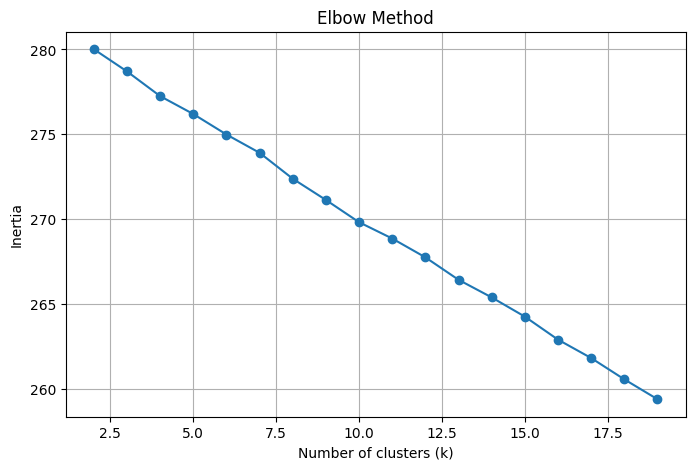

In [274]:
# -----*** Elbow Method ***-----
inertias = []

for k in range(2, 20):
    print(f"------- k = {k} -------")
    
    kmeans, labels = fit_kmeans(x_tfidf, k)

    unique, counts = np.unique(labels, return_counts=True)
    for lbl, cnt in zip(unique, counts):
        print(f"Cluster {lbl}: {cnt} hekayat")
    
    nmi = normalized_mutual_info_score(df["bab"], labels)
    print("NMI:", nmi)

    threshold = 0.15 * np.mean(counts)  # 15% deviation allowed
    print("Are clusters balanced?", np.std(counts) < threshold)
    
    inertias.append(kmeans.inertia_)

    df_clusters = pd.DataFrame({
    "cluster": labels,
    "bab": df["bab"]
})

    cluster_groups = df_clusters.groupby("cluster")["bab"].value_counts()
    print(cluster_groups)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 20), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True)
plt.show()


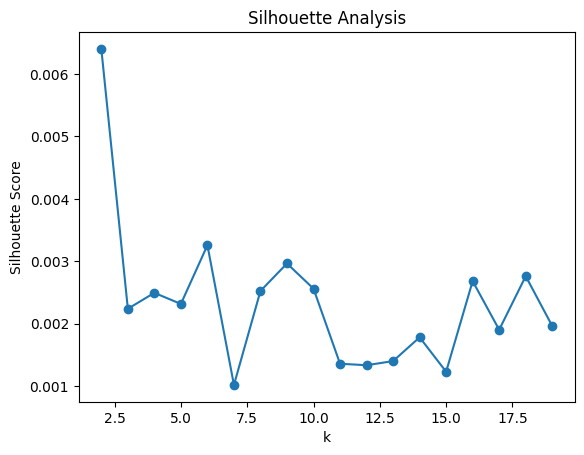

In [270]:
# -----*** Silhouette Score ***-----
sil_scores = []

for k in range(2, 20):
    km, labels = fit_kmeans(x_tfidf, k)
    score = silhouette_score(x_tfidf, labels, metric="cosine")
    sil_scores.append(score)

plt.plot(range(2, 20), sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()


In [271]:
print("Best k by silhouette:", np.argmax(sil_scores))

Best k by silhouette: 0


K=4


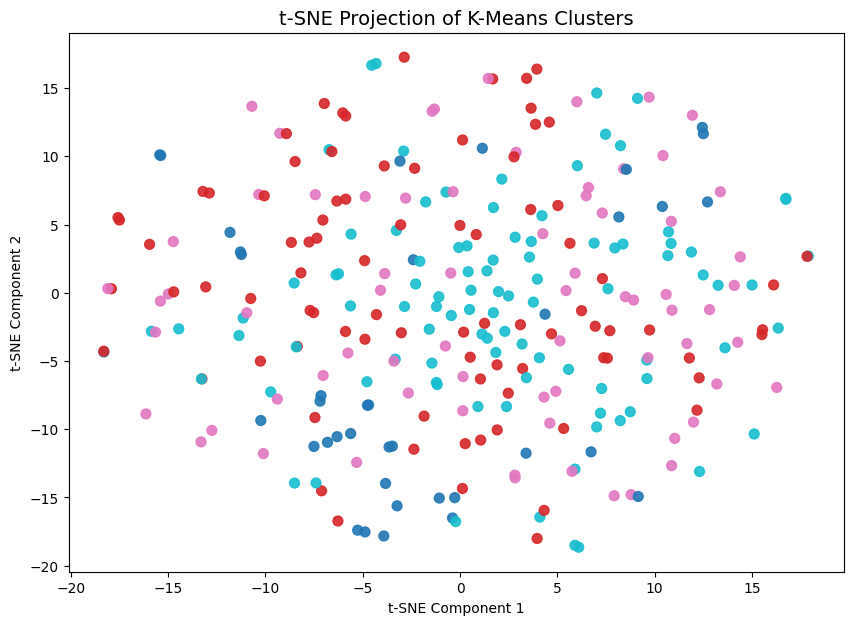

K=5


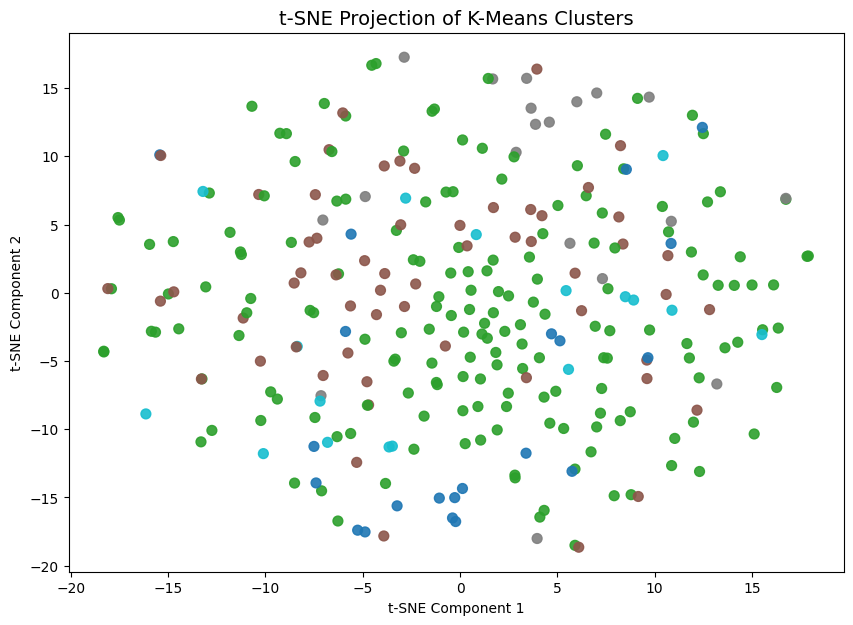

K=6


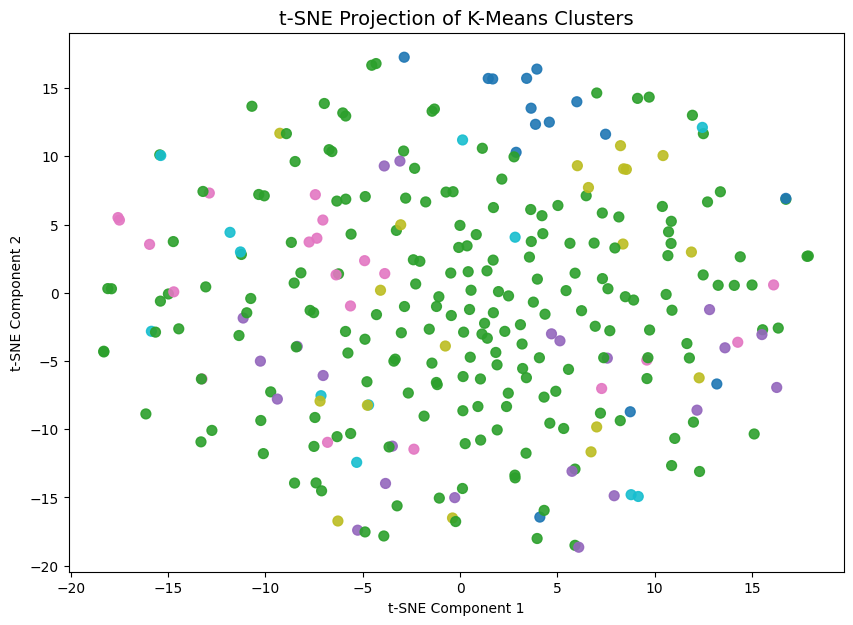

K=7


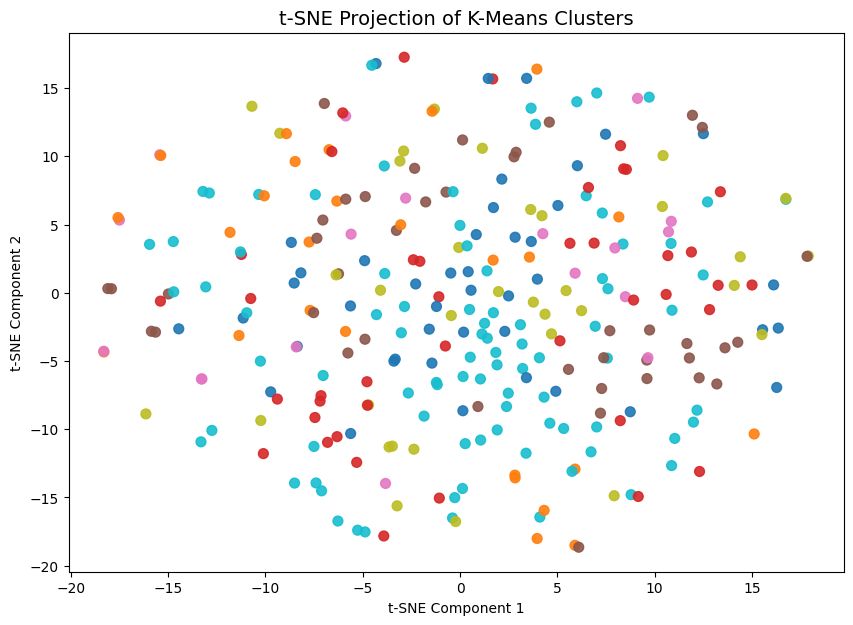

In [273]:
for k in range(4, 8):
    print(f"K={k}")
    kmeans, labels = fit_kmeans(x_tfidf, k)
    plot_clusters_tsne(x_tfidf, labels)


Mathematical answer

→ k = 2

Semantically meaningful clustering

→ k = 4, 5, 6, or 7

Closest to Golestan’s 8 bāb

→ k = 8

Best compromise for report quality

→ k = 5 or k = 6